# Part4 Final Evaluation and Comparison

In [ ]:
#[Cell 43] — Load artifacts (essential)

import json, numpy as np, torch
from pathlib import Path
from vae import VAE
from vqvae_baseline import VQVAE
from transformers import GPT2LMHeadModel

#Paths and device
ROOT = Path.cwd()
RESULTS_PATH = ROOT / "results"
GEO = RESULTS_PATH / "geodesic_quant"
BASELINE_DIR = RESULTS_PATH / "vqvae_baseline"
OUT_DIR = ROOT / "output_imgs" / "Part3"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Main metadata
with open(GEO / "geoq_summary.json") as f:
    meta = json.load(f)
N_IMAGES, H, W, D = meta["N_images"], meta["H"], meta["W"], meta["D"]
L = H * W
K = 128  #as used in previous parts

#Continuous VAE (decoder used for GeoQ)
VAE_CKPT = RESULTS_PATH / "vae_cifar10.pth"
assert VAE_CKPT.exists()
vae = VAE(latent_dim=D).to(DEVICE)
vae.load_state_dict(torch.load(VAE_CKPT, map_location=DEVICE))
vae.eval()
decoder_vae = vae.decoder  #(N,D,4,4) -> (N,3,32,32)

#Fine-tuned decoder for GeoQ
VAE_FT_CKPT = RESULTS_PATH / "vae_cifar10_finetuned_decoder.pth"
assert VAE_FT_CKPT.exists()
vae_geoq = VAE(latent_dim=D).to(DEVICE)
vae_geoq.load_state_dict(torch.load(VAE_FT_CKPT, map_location=DEVICE))
vae_geoq.eval()
decoder_vae_geoq = vae_geoq.decoder  #updated decoder

#Geodesic prototypes/codes
PROT_STD = GEO / "geoq_prototypes.npy"
PROT_RAW = GEO / "geoq_prototypes_raw.npy"
ASSIGN_ALL = GEO / "geoq_assignments_all.npy"
assert PROT_STD.exists() and PROT_RAW.exists() and ASSIGN_ALL.exists()
prototypes_std = np.load(PROT_STD)          #(K,D)
prototypes_raw = np.load(PROT_RAW)          #(K,D)
assignments_all = np.load(ASSIGN_ALL)       #(N_images*L,)

#Transformer prior (geodesic)
TRANSFORMER_GEOQ_DIR = RESULTS_PATH / "transformer_geoq_prior"
prior_geoq = GPT2LMHeadModel.from_pretrained(str(TRANSFORMER_GEOQ_DIR)).to(DEVICE).eval()

#VQ-VAE baseline + baseline prior
VQVAE_CKPT = BASELINE_DIR / "vqvae_baseline.pth"
assert VQVAE_CKPT.exists()
vqvae = VQVAE(K=K, D=D).to(DEVICE)
ckpt = torch.load(VQVAE_CKPT, map_location=DEVICE)
vqvae.load_state_dict(ckpt["model_state"])
vqvae.eval()
TRANSFORMER_BASE_DIR = BASELINE_DIR / "transformer_baseline_prior"
prior_base = GPT2LMHeadModel.from_pretrained(str(TRANSFORMER_BASE_DIR)).to(DEVICE).eval()

#Generated/reconstructed samples
GEOQ_CODES = GEO / "transformer_samples_codes.npy"
GEOQ_LAT   = GEO / "transformer_samples_latents.npy"
BASE_CODES = BASELINE_DIR / "vqvae_baseline_samples_codes.npy"
BASE_IMGS  = BASELINE_DIR / "vqvae_baseline_samples_images.npy"
geoq_codes = np.load(GEOQ_CODES) if GEOQ_CODES.exists() else None         #(N,4,4)
geoq_lat   = np.load(GEOQ_LAT)   if GEOQ_LAT.exists()   else None         #(N,D,4,4)
base_codes = np.load(BASE_CODES) if BASE_CODES.exists() else None         #(N,4,4)
base_imgs  = np.load(BASE_IMGS)  if BASE_IMGS.exists()  else None         #(N,3,32,32)

#Ready-to-use objects
ART = {
    "meta": dict(N_IMAGES=N_IMAGES, H=H, W=W, D=D, L=L, K=K),
    "vae": vae,  #continuous baseline
    "decoder_vae_geoq": decoder_vae_geoq,  #fine-tuned decoder for GeoQ
    "prototypes_std": prototypes_std,
    "prototypes_raw": prototypes_raw,
    "assignments_all": assignments_all,
    "prior_geoq": prior_geoq,
    "vqvae": vqvae,
    "prior_base": prior_base,
    "geoq_codes": geoq_codes,
    "geoq_lat": geoq_lat,
    "base_codes": base_codes,
    "base_imgs": base_imgs,
    "paths": dict(
        RESULTS=str(RESULTS_PATH),
        GEO=str(GEO),
        BASE=str(BASELINE_DIR),
        OUT=str(OUT_DIR),
    ),
}


### [Cell 44] Reconstruction (visual + MAE)
* **Goal:** measure how faithfully each model reconstructs input images.  
* **Visual:** side-by-side plots of  
  * Original image,  
  * Continuous VAE reconstruction,  
  * Post-hoc Geodesic Quantization reconstruction,  
  * End-to-end VQ-VAE baseline reconstruction.  
* **Quantitative (MAE):**  
  * Continuous VAE = **0.0424**  
  * Geodesic pipeline = **0.0993**  
  * VQ-VAE baseline = **0.0767**  
* **Interpretation:** baseline preserves more detail than geodesic, but both add quantization cost compared to the continuous VAE.  


MAE_test — VAE:0.04242 | GeoQuant:0.09926 | VQ-VAE:0.07671


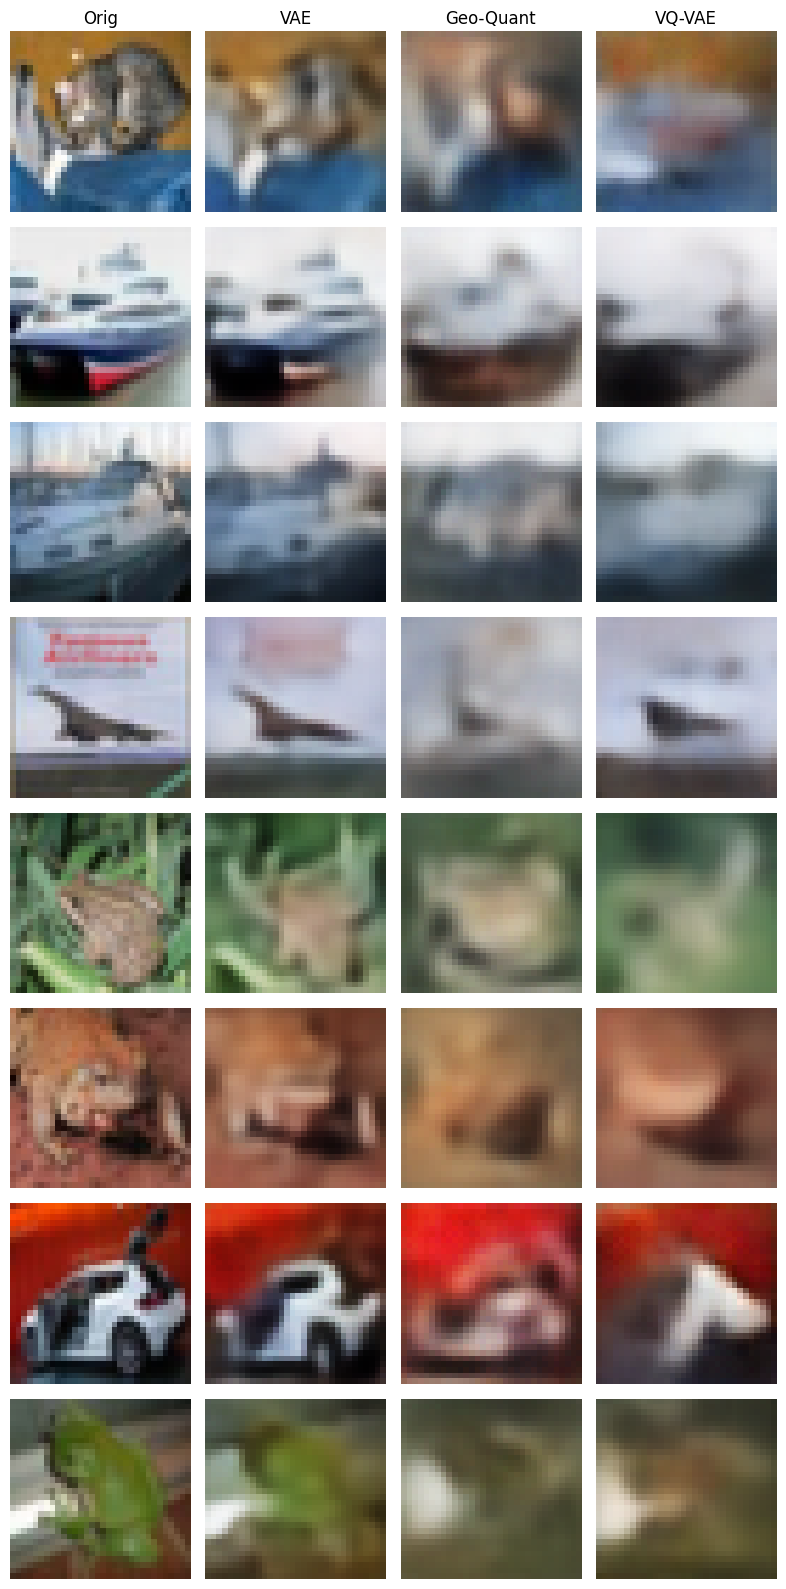

In [ ]:
#[Cell 44] — Reconstruction evaluation (visual + MAE)

import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
DATA = ROOT / "data"

#Test dataloader
tfm = transforms.ToTensor()
test_set = datasets.CIFAR10(root=str(DATA), train=False, download=False, transform=tfm)
test_loader = DataLoader(test_set, batch_size=256, shuffle=False, num_workers=4, pin_memory=torch.cuda.is_available())

#Prototype tensors for simple quantization (nearest medoid in std-space)
prot_std_t = torch.from_numpy(prototypes_std.astype(np.float32)).to(DEVICE)   #(K,D)
prot_raw_t = torch.from_numpy(prototypes_raw.astype(np.float32)).to(DEVICE)  #(K,D)

#Function: quantize mu (B,D,4,4) via nearest-medoid std and decode
stats = np.load(GEO / "geoq_standardization_stats.npz")
mu_train = torch.from_numpy(stats["mu"].astype(np.float32)).to(DEVICE)        #(D,)
sigma_train = torch.from_numpy(stats["sigma"].astype(np.float32)).to(DEVICE)  #(D,)

def geoq_reconstruct_from_mu(mu_bdhw: torch.Tensor, decoder_vae_geoq) -> torch.Tensor:
    #mu_bdhw: (B,D,H,W)
    B = mu_bdhw.size(0)
    mu_hwD = mu_bdhw.permute(0,2,3,1).contiguous()   #(B,H,W,D)

    #standardize as in fine-tuning
    mu_std = (mu_hwD - mu_train.view(1,1,1,-1)) / (sigma_train.view(1,1,1,-1) + 1e-6)
    z_flat = mu_std.view(-1, D)

    #NN over prot_std
    z2 = (z_flat**2).sum(dim=1, keepdim=True)
    e2 = (prot_std_t**2).sum(dim=1).view(1,-1)
    dist2 = z2 + e2 - 2.0 * (z_flat @ prot_std_t.t())
    idx = dist2.argmin(dim=1)

    #Decoder input: std prototypes
    z_sel = prot_std_t.index_select(0, idx).view(B, H, W, D).permute(0,3,1,2).contiguous()
    with torch.no_grad():
        x_rec = decoder_vae_geoq(z_sel).clamp(0,1)
    return x_rec

#MAE over full test set + visualization on a small batch
mae_vae = mae_geoq = mae_vqvae = 0.0
n_pix_acc = 0

#small batch for visualization
vis_batch = next(iter(test_loader))[0][:8].to(DEVICE)

with torch.no_grad():
    #visual: reconstructions for 8 examples
    rec_vae_vis, mu_vis, _ = vae(vis_batch)
    rec_geoq_vis = geoq_reconstruct_from_mu(mu_vis, decoder_vae_geoq)
    rec_vq_vis, _, _, _ = vqvae(vis_batch)
    rec_vq_vis = rec_vq_vis.clamp(0,1)

for x, _ in test_loader:
    x = x.to(DEVICE, non_blocking=True)
    B = x.size(0)
    with torch.no_grad():
        rec_vae, mu, _ = vae(x)
        rec_geoq = geoq_reconstruct_from_mu(mu, decoder_vae_geoq)
        rec_vq, _, _, _ = vqvae(x)
        rec_vq = rec_vq.clamp(0,1)

    #Aggregate MAE (sum of absolutes / total number of pixels)
    mae_vae += torch.sum(torch.abs(rec_vae - x)).item()
    mae_geoq += torch.sum(torch.abs(rec_geoq - x)).item()
    mae_vqvae += torch.sum(torch.abs(rec_vq - x)).item()
    n_pix_acc += B * 3 * 32 * 32

mae_vae /= n_pix_acc
mae_geoq /= n_pix_acc
mae_vqvae /= n_pix_acc

print(f"MAE_test — VAE:{mae_vae:.5f} | GeoQuant:{mae_geoq:.5f} | VQ-VAE:{mae_vqvae:.5f}")

#Visualization: 8 rows (images) × 4 columns (Orig, VAE, Geo, VQ)
def to_np_img(t): return t.detach().cpu().permute(1,2,0).numpy()

fig, axes = plt.subplots(8, 4, figsize=(8, 16))
for i in range(8):
    axes[i,0].imshow(to_np_img(vis_batch[i]));     axes[i,0].axis("off")
    axes[i,1].imshow(to_np_img(rec_vae_vis[i]));   axes[i,1].axis("off")
    axes[i,2].imshow(to_np_img(rec_geoq_vis[i]));  axes[i,2].axis("off")
    axes[i,3].imshow(to_np_img(rec_vq_vis[i]));    axes[i,3].axis("off")
axes[0,0].set_title("Orig"); axes[0,1].set_title("VAE"); axes[0,2].set_title("Geo-Quant"); axes[0,3].set_title("VQ-VAE")
plt.tight_layout(); plt.show()


### [Cell 45] Generative Capacity (samples + FID/IS)
* **Goal:** evaluate how well the AR priors generate *new* images.  
* **Process:** thousands of samples are drawn from  
  * Transformer prior (geodesic codes),  
  * Transformer prior (VQ-VAE baseline codes).  
* **Metrics:**  
  * **FID (lower is better):** compares real vs. generated distributions in Inception feature space.  
  * **Inception Score (higher is better):** measures both realism and diversity.  
* **Qualitative check:** visual inspection of generated images for realism, coherence, and diversity.  
* **Outcome:** provides the key comparison of **generative quality** between the geodesic and baseline pipelines.  

c:\Users\lucam\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\integrations\sdpa_attention.py:89: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
c:\Users\lucam\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\feature_extraction.py:174: UserWarning: NOTE: The nodes obtained by tracing the model in eval mode are a subsequence of those obtained in train mode. When choosing nodes for feature extraction, you may need to specify output nodes for train and eval mode separately.
  warnings.warn(msg + suggestion_msg)


FID (↓) — Geo:176.78 | Baseline:132.15
Inception Score (↑) — Geo:1.76±0.02 | Baseline:2.29±0.03


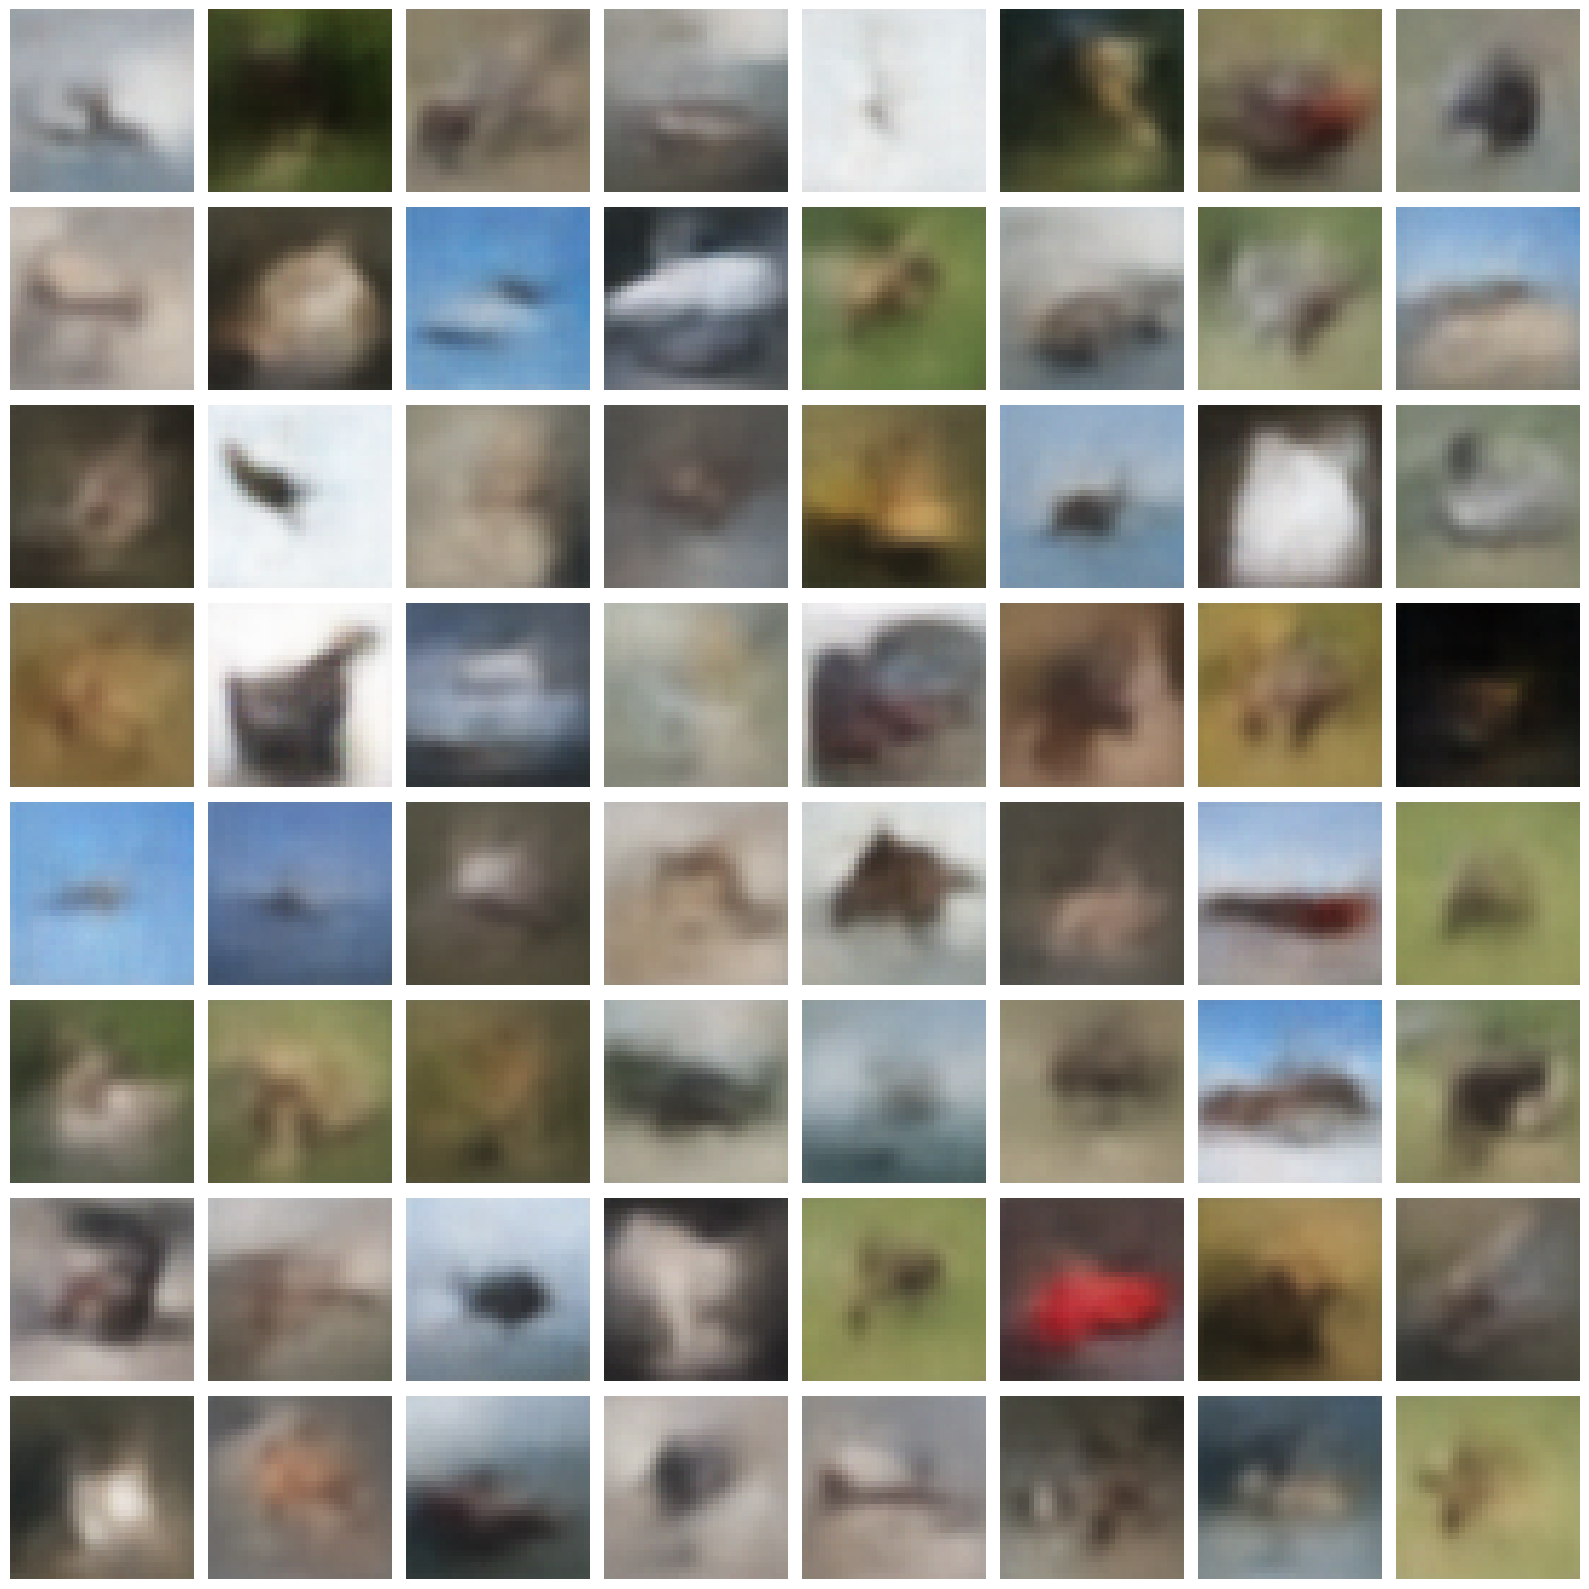

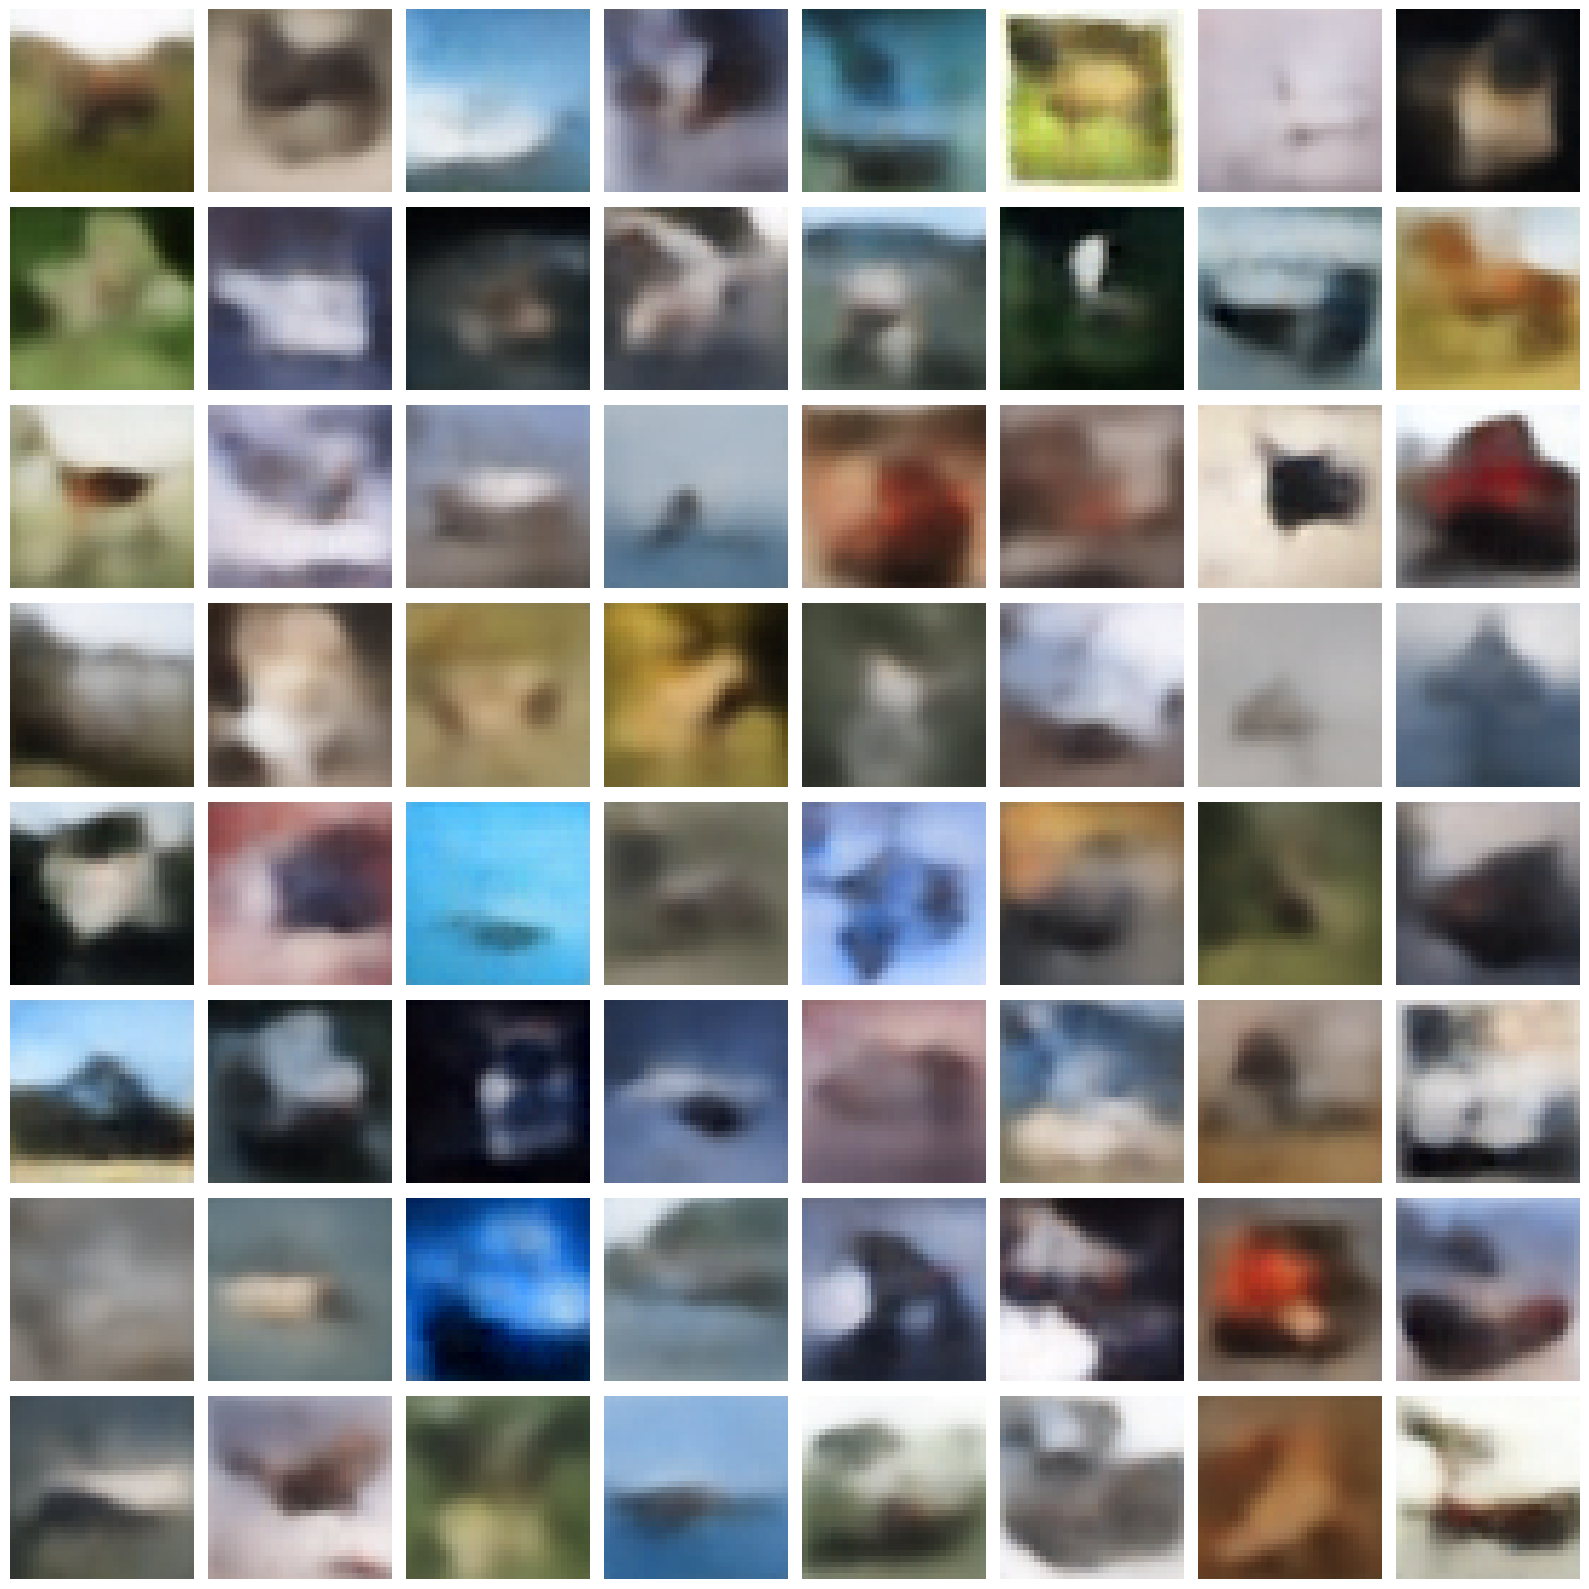

In [ ]:
#[Cell 45] — Generative Capacity: samples + FID & Inception Score (essential)

import math, json, numpy as np, torch, torch.nn.functional as F
from pathlib import Path
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
from transformers import GPT2LMHeadModel
from vae import VAE
from vqvae_baseline import VQVAE
from torchvision.models import inception_v3, Inception_V3_Weights
from torchvision.models.feature_extraction import create_feature_extractor
from scipy.linalg import sqrtm

#Device & paths
RESULTS = ROOT / "results"
GEO = RESULTS / "geodesic_quant"
BASE = RESULTS / "vqvae_baseline"
DATA = ROOT / "data"

#Metadata & geodesic assets
meta = json.loads((GEO / "geoq_summary.json").read_text())
H, W, D = meta["H"], meta["W"], meta["D"]
L = H * W
prototypes_raw = np.load(GEO / "geoq_prototypes_raw.npy").astype(np.float32)  #(K, D)
K = prototypes_raw.shape[0]
pos_marg = np.load(GEO / "geoq_pos_marginals.npy") if (GEO / "geoq_pos_marginals.npy").exists() else None

vqvae = VQVAE(K=K, D=D).to(DEVICE).eval()
ckpt = torch.load(BASE / "vqvae_baseline.pth", map_location=DEVICE)
vqvae.load_state_dict(ckpt["model_state"], strict=False)

#Autoregressive priors
prior_geoq = GPT2LMHeadModel.from_pretrained(str(RESULTS / "transformer_geoq_prior")).to(DEVICE).eval()
prior_base = GPT2LMHeadModel.from_pretrained(str(BASE / "transformer_baseline_prior")).to(DEVICE).eval()

#Sampling helpers
def _top_p_sample(logits, top_p=0.9, temperature=1.0):
    logits = logits / max(1e-8, float(temperature))
    probs = torch.softmax(logits, dim=-1)
    sorted_probs, sorted_idx = torch.sort(probs, descending=True, dim=-1)
    cum = torch.cumsum(sorted_probs, dim=-1)
    keep = cum <= top_p
    keep[..., 0] = True
    filtered = torch.where(keep, sorted_probs, torch.zeros_like(sorted_probs))
    filtered = filtered / filtered.sum(dim=-1, keepdim=True)
    idx = torch.multinomial(filtered, 1)
    return sorted_idx.gather(-1, idx).squeeze(-1)

def sample_prior(model, N, L, K, top_p=0.9, temperature=1.0, p0=None, bs=512):
    out = np.empty((N, L), dtype=np.int64); s = 0
    rng = np.random.default_rng(42)
    model.eval()
    while s < N:
        n = min(bs, N - s)
        start = rng.choice(K, size=n, p=p0)
        input_ids = torch.from_numpy(start).long().unsqueeze(1).to(DEVICE)  #(n,1)
        attn = torch.ones_like(input_ids)                                   #(n,1)
        with torch.no_grad():
            for _ in range(1, L):
                logits = model(input_ids, attention_mask=attn).logits[:, -1, :]
                nxt = _top_p_sample(logits, top_p=top_p, temperature=temperature).unsqueeze(1)
                input_ids = torch.cat([input_ids, nxt], dim=1)              #(n,t+1)
                attn = torch.ones_like(input_ids)                           #update mask
        out[s:s+n] = input_ids.cpu().numpy(); s += n
    return out

def codes_to_latents_geoq(codes_hw: np.ndarray, prototypes_std: np.ndarray) -> torch.Tensor:
    N = codes_hw.shape[0]
    idx = torch.from_numpy(codes_hw.reshape(N, -1)).long().to(DEVICE)     #(N,16)
    prot = torch.from_numpy(prototypes_std).to(DEVICE)                     #(K,D)
    z_flat = prot.index_select(0, idx.view(-1)).view(N, H, W, D)
    return z_flat.permute(0, 3, 1, 2).contiguous()                         #(N,D,4,4)

def codes_to_latents_vqvae(codes_hw: np.ndarray, vqvae: VQVAE) -> torch.Tensor:
    N = codes_hw.shape[0]
    idx = torch.from_numpy(codes_hw.reshape(N, -1)).long().to(DEVICE)     #(N,16)
    emb = vqvae.vq.embedding.weight                                       #(K,D)
    z_flat = emb.index_select(0, idx.view(-1)).view(N, H, W, emb.size(1))
    return z_flat.permute(0, 3, 1, 2).contiguous()                         #(N,D,4,4)

#Generate samples (N per method)
N_GEN = 10000
p0_geoq = (pos_marg[0] / pos_marg[0].sum()) if 'pos_marg' in globals() and pos_marg is not None else None

codes_geo  = sample_prior(prior_geoq,  N_GEN, L, K, top_p=0.9, temperature=1.0, p0=p0_geoq)
codes_geo_hw  = codes_geo.reshape(N_GEN, H, W)
z_geo = codes_to_latents_geoq(codes_geo_hw, prototypes_std)
with torch.no_grad(): imgs_geo = decoder_vae_geoq(z_geo).clamp(0,1).cpu()

codes_base = sample_prior(prior_base, N_GEN, L, K, top_p=0.9, temperature=1.0, p0=None)
codes_base_hw = codes_base.reshape(N_GEN, H, W)
z_base = codes_to_latents_vqvae(codes_base_hw, vqvae)
with torch.no_grad(): imgs_base = vqvae.decoder(z_base).clamp(0,1).cpu()  #(N,3,32,32)

#Real images (CIFAR-10 test)
tfm = transforms.ToTensor()
real_set = datasets.CIFAR10(root=str(DATA), train=False, download=False, transform=tfm)
real_loader = DataLoader(real_set, batch_size=256, shuffle=False, num_workers=4, pin_memory=torch.cuda.is_available())

weights = Inception_V3_Weights.DEFAULT
inc = inception_v3(weights=weights).to(DEVICE).eval()

feat_extractor = create_feature_extractor(
    inc,
    return_nodes={'avgpool': 'pool'}   #only this layer
).to(DEVICE).eval()

mean = torch.tensor([0.485, 0.456, 0.406], device=DEVICE).view(1,3,1,1)
std  = torch.tensor([0.229, 0.224, 0.225], device=DEVICE).view(1,3,1,1)

def preprocess_299(x):
    return F.interpolate(x, size=(299,299), mode='bilinear', align_corners=False).sub_(mean).div_(std)

@torch.no_grad()
def activations_and_probs(x: torch.Tensor, bs=256):
    feats, probs = [], []
    for i in range(0, x.size(0), bs):
        xb = preprocess_299(x[i:i+bs].to(DEVICE))
        f = feat_extractor(xb)['pool'].squeeze(-1).squeeze(-1)            #(b,2048)
        logits = inc(xb)                                                  #(b,1000)
        feats.append(f.cpu().numpy())
        probs.append(torch.softmax(logits, dim=1).cpu().numpy())
    return np.concatenate(feats, 0), np.concatenate(probs, 0)

@torch.no_grad()
def real_activations(loader):
    feats = []
    for x, _ in loader:
        xb = preprocess_299(x.to(DEVICE))
        f = feat_extractor(xb)['pool'].squeeze(-1).squeeze(-1)
        feats.append(f.cpu().numpy())
    return np.concatenate(feats, 0)

def fid_from_feats(f_real, f_fake):
    mu1, mu2 = f_real.mean(0), f_fake.mean(0)
    s1, s2 = np.cov(f_real, rowvar=False), np.cov(f_fake, rowvar=False)
    covmean = sqrtm(s1.dot(s2)).real
    return float(((mu1 - mu2)**2).sum() + np.trace(s1 + s2 - 2*covmean))

def inception_score(probs, eps=1e-16, splits=10):
    N = probs.shape[0]; split = N // splits
    scores = []
    for i in range(splits):
        p_yx = probs[i*split:(i+1)*split]
        p_y = np.clip(p_yx.mean(0, keepdims=True), eps, 1.0)
        kl = (p_yx * (np.log(np.clip(p_yx, eps, 1.0)) - np.log(p_y))).sum(axis=1)
        scores.append(np.exp(kl.mean()))
    return float(np.mean(scores)), float(np.std(scores))

#Compute activations/probs
f_real = real_activations(real_loader)
f_geo, p_geo = activations_and_probs(imgs_geo)
f_base, p_base = activations_and_probs(imgs_base)

#Metrics
FID_geo  = fid_from_feats(f_real, f_geo)
FID_base = fid_from_feats(f_real, f_base)
IS_geo_m, IS_geo_s   = inception_score(p_geo)
IS_base_m, IS_base_s = inception_score(p_base)

print(f"FID (↓) — Geo:{FID_geo:.2f} | Baseline:{FID_base:.2f}")
print(f"Inception Score (↑) — Geo:{IS_geo_m:.2f}±{IS_geo_s:.2f} | Baseline:{IS_base_m:.2f}±{IS_base_s:.2f}")

#Qualitative: quick 8×8 grid for each method
import matplotlib.pyplot as plt
def grid(imgs, n=64):
    x = imgs[:n].permute(0,2,3,1).numpy()
    r = int(math.sqrt(n)); c = int(math.ceil(n/r))
    fig, axes = plt.subplots(r, c, figsize=(c*2, r*2))
    for i, ax in enumerate(axes.flat):
        if i < n: ax.imshow(x[i]); ax.axis('off')
    plt.tight_layout(); plt.show()

grid(imgs_geo, n=64)
grid(imgs_base, n=64)
